Jeff Dunagin

DSC 530

Exercise 11.2

27 February 2022

# 13.1
In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [1]:
# imports
import nsfg
import numpy as np
import pandas as pd
import survival
import thinkstats2
import thinkplot

In [2]:
# data
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [3]:
# clean data
resp6.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

resp6['notdivorced'] = resp6.cmdivorcx.isnull().astype(int)
resp6['duration'] = (resp6.cmdivorcx - resp6.cmmarrhx) / 12.0
resp6['durationsofar'] = (resp6.cmintvw - resp6.cmmarrhx) / 12.0

month0 = pd.to_datetime('1899-12-15')
dates = [month0 + pd.DateOffset(months=cm) 
         for cm in resp6.cmbirth]
resp6['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

# clean data
resp7.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

resp7['notdivorced'] = resp7.cmdivorcx.isnull().astype(int)
resp7['duration'] = (resp7.cmdivorcx - resp7.cmmarrhx) / 12.0
resp7['durationsofar'] = (resp7.cmintvw - resp7.cmmarrhx) / 12.0

month0 = pd.to_datetime('1899-12-15')
dates = [month0 + pd.DateOffset(months=cm) 
         for cm in resp7.cmbirth]
resp7['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [4]:
married6 = resp6[resp6.evrmarry==1]
married7 = resp7[resp7.evrmarry==1]

In [5]:
# functions

def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])
    
def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames    
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[0, 28, 0, 1])
    
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)
        
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

The functions here estimate the hazard and survival curves. We can plot the hazard curves

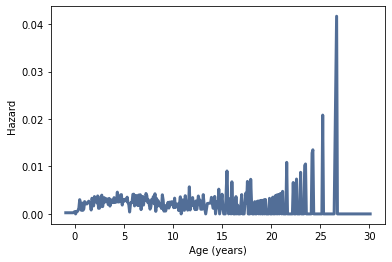

In [6]:
hf, sf = EstimateSurvival(resp6)

thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

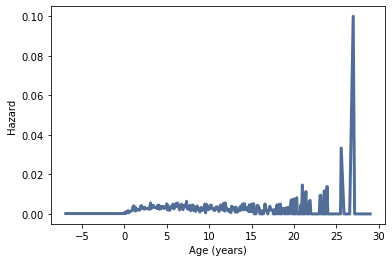

In [7]:
hf, sf = EstimateSurvival(resp7)

thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

The data is noisy and probably not very useful >20 years.

We will now resample and plot the divorce surve (survival function) by decade:

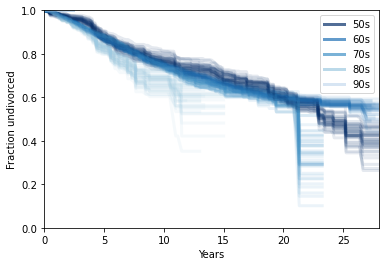

In [8]:
ResampleDivorceCurveByDecade([married6, married7])

Here we have the estimated survival curve of marriages for each decade.